# Introduction

L'objectif de ce notebook est d'effectuer les opération nécessaires au preprocessing des images. Nous allons:


*   Déplacer chaque image dans un sous-dossier propre à sa classe d'appartenance
*   Zoomer les images qui le nécessitent



# Initialisation

In [1]:
random_state = 123
output_dir = "output/data-preprocessing-images"

In [2]:
from pathlib import Path
import shutil
from tqdm import tqdm
import zipfile
import sys
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [3]:

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    %cd drive/MyDrive/nov23_bds_rakuten
else:
    root_files = os.listdir()
    if not "requirements.txt" in root_files:
        print("The jupyter server root should be set to root of git project")
        print("If you're on vscode add the following to your settings.json file")
        print('"jupyter.notebookFileRoot": "${workspaceFolder}"')

Mounted at /content/drive/
/content/drive/MyDrive/nov23_bds_rakuten


# Import des images

In [4]:
if 'google.colab' in sys.modules:
    image_path = "/tmp/rakuten-images"
    image_dir = Path(image_path)
    if image_dir.exists():
        print("images already imported from drive")
    else:
        print("extracting images from drive into colab's session storage... (about 1 min)")
        with zipfile.ZipFile("data/images.zip","r") as images_zip:
            images_zip.extractall(image_path)
        image_path = image_path + "/images"
else:
    image_path = "data/images"

extracting images from drive into colab's session storage... (about 1 min)


# Import des données csv

Chargeons le cv qui contient les données preprocessed par le notebook [data-exploration](https://drive.google.com/file/d/1nDqn0VCiZqWur1EA0bXreOvYLXPHVAln/view?usp=drive_link) puis traduites par le [notebook de traduction](https://drive.google.com/file/d/1mPzJFB7pfR0tPfw4ov2qgGIs0BpTgBIZ/view?usp=drive_link)

In [5]:
df = pd.read_csv('output/traduction_fr/X_train_trad_fr.csv', index_col=0)
df.head()

,productid,imageid,prdtypecode,text,lang,text_fr
index,,,,,,
0,3804725264,1263597046,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,de,Olivia: cahier personnalisé / 150 pages / gril...
1,436067568,1008141237,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,fr,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...
2,201115110,938777978,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,fr,Grand Stylet Ergonomique Bleu Gamepad Nintendo...
3,50418756,457047496,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,de,Peluche Donald - Europe - Disneyland 2000 (Mar...
4,278535884,1077757786,2705,La Guerre Des Tuques - Luc a des idées de gran...,fr,La Guerre Des Tuques - Luc a des idées de gran...


Il faut aussi récupérer les infos sur les images du notebook exportées depuis le notebook [data-exploration](https://drive.google.com/file/d/1nDqn0VCiZqWur1EA0bXreOvYLXPHVAln/view?usp=drive_link)

In [6]:
df_img = pd.read_csv('output/data-exploration/images.csv', index_col=0)
df_img.head()

,imageempty,imagewidth,imageheight,innerimagetop,innerimageleft,innerimagebottom,innerimageright,innerimageratio
index,,,,,,,,
0,False,500,500,143,175,352,320,0.418
1,False,500,500,111,159,384,352,0.546
2,False,500,500,63,72,432,432,0.738
3,False,500,500,47,79,447,416,0.800
4,False,500,500,95,159,399,352,0.608


On va merge **df_img** dans **df** en se basant sur leurs indexes respectifs

In [7]:
prev_df_len = df.shape[0]
df = df.merge(right=df_img,how="inner",left_index=True,right_index=True)
df.info()
if df.shape[0] == df_img.shape[0] == prev_df_len:
  print("Le merge s'est bien passé")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   productid         84916 non-null  int64  
 1   imageid           84916 non-null  int64  
 2   prdtypecode       84916 non-null  int64  
 3   text              84916 non-null  object 
 4   lang              84916 non-null  object 
 5   text_fr           84916 non-null  object 
 6   imageempty        84916 non-null  bool   
 7   imagewidth        84916 non-null  int64  
 8   imageheight       84916 non-null  int64  
 9   innerimagetop     84916 non-null  int64  
 10  innerimageleft    84916 non-null  int64  
 11  innerimagebottom  84916 non-null  int64  
 12  innerimageright   84916 non-null  int64  
 13  innerimageratio   84916 non-null  float64
dtypes: bool(1), float64(1), int64(9), object(3)
memory usage: 11.2+ MB
Le merge s'est bien passé


Le merge s'est bien déroulé, on ne constate pas de données manquantes

# Déplacement des images dans leurs sous-dossiers de classes

On peut désormais ajouter une colonne **imagefile** à **df** qui nous servira dans les notebooks de modélisation d'images.

In [8]:
df['imagefile'] = "image_" + df["imageid"].astype("str")+"_product_"+df["productid"].astype("str")+".jpg"

Afin de nous faciliter la vie, nous allons repartir les images dans plusieurs sous-dossiers par catégories. C'est une hiérarchie qui est bien acceptée par les générateurs d'images utilisés dans le cadre du deep learning.

In [9]:
for index,row in tqdm(df.iterrows()):
  c = str(row['prdtypecode'])
  file = row['imagefile']
  Path(image_path+"/"+c).mkdir(exist_ok=True)
  os.rename(image_path+"/"+file,image_path+"/"+c+"/"+file)

84916it [00:15, 5435.09it/s]


N'oublions pas de mettre à jour la colonne **imagefile** pour y ajouter en prefix le dossier de la catégorie

In [10]:
df['imagefile'] = df['prdtypecode'].astype("str") + "/" + df['imagefile']

# Zoom des images

Nous allons maintenant procéder au zoom des images avec des bords blancs importants.

Commençons par définir une fonction qui effectue le zoom d'une image

In [11]:
def zoom_img(img_path,box):
	"""
	Zoom inner image contained into image with img_path while
	preserving both image ratio of inner image and original image size.

	Args:
		img_path: Path of image
		box: Bounding box of inner image as a tuple (top,left,bottom,right)

	Returns:
		np.array containing zoomed image. It is garanteed to have the same
		dimensions than original image

	"""
	img = cv2.imread(img_path,cv2.IMREAD_COLOR)
	zoomed_img = img[box[0]:box[2]+1,box[1]:box[3]+1]
	zoomed_w,zoomed_h = (zoomed_img.shape[1],zoomed_img.shape[0])
	img_w,img_h = (img.shape[1],img.shape[0])
	if zoomed_w > zoomed_h:
		size = (img_w,int(zoomed_h * (img_w / zoomed_w)))
	else:
		size = (int(zoomed_w * (img_h / zoomed_h)),img_h)
	zoomed_img = cv2.resize(zoomed_img,dsize=size,interpolation=cv2.INTER_LINEAR)
	final_img = np.full(shape=img.shape,fill_value=255,dtype=np.uint8)
	new_x = (final_img.shape[1]-zoomed_img.shape[1])//2
	new_y = (final_img.shape[0]-zoomed_img.shape[0])//2

	final_img[new_y:new_y + zoomed_img.shape[0], new_x:new_x + zoomed_img.shape[1]] = zoomed_img
	return final_img

Avant de procéder d'aller plus loin, nous allons charger quelques unes des images originales avec différent ratio de taille d'image internes.

Elles nous servirons de comparaisons après le zoom, pour vérifier que l'opération s'est bien déroulé

In [12]:
original_images = []
for max_ratio in np.arange(0.1,1.0,0.1):
  index = df[(df['innerimageratio'] > (max_ratio-0.1)) & (df['innerimageratio'] <= max_ratio)]\
    .sort_values('innerimageratio').index[0]
  row = df.loc[index]
  img = cv2.imread(image_path+"/"+row['imagefile'],cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  original_images.append((index,img))


Nous pouvons enfin procéder au zoom des images. Comme annoncé dans le notebook data-exploration, nous allons zoomer toutes les images ayant un **innerimageratio** inférieur ou égal à 0.8

In [13]:
for index in tqdm(df[df['innerimageratio'] <= 0.8].index):
#for index,old_img in tqdm(original_images):
  row = df.loc[index]
  img = zoom_img(
      image_path+"/"+row['imagefile'],
      (row['innerimagetop'],row['innerimageleft'],row['innerimagebottom'],row['innerimageright'])
  )
  cv2.imwrite(image_path+"/"+row['imagefile'],img)

100%|██████████| 15586/15586 [03:47<00:00, 68.59it/s]


Reprenons depuis **data-exploration.ipynb** la fonction **plot_img_with_box** qui nous permet d'afficher une image avec sa bounding box. On va juste l'adapter ses paramètres pour qu'elle accepte directement une image chargée et sa bounding box.

In [14]:
def plot_img_with_box(img,top,left,bottom,right):
  plt.imshow(img)
  x = [left,right,right,left,left]
  y = [top,top,bottom,bottom,top]
  plt.plot(x,y,"r--")
  plt.xticks([])
  plt.yticks([])

Récupérons également la fonction **find_inner_img_box** qui va nous servir à recalculer la bounding box séparant l'image interne des bords blancs sur les images zoomées

In [15]:
def find_inner_img_box(img):
	"""
	Return the bounding box of inner image.	This is usefull
	for images that are surronded by a big blank area

	Args:
		img: RGB image as an np.array

	Returns:
		Bounding box of inner image as a tuple (top,left,bottom,right)
		or None if image if all blank
	"""

	#top
	for top in range(img.shape[0]):
		if (img[top] != 255).any():
			break

	if top == img.shape[0]-1:
		#img is all blank so return None
		return None

	#bottom
	for bottom in range(img.shape[0]-1,top,-1):
		if (img[bottom] != 255).any():
			break
	#left
	for left in range(img.shape[1]):
		if (img[top:bottom+1,left] != 255).any():
			break
	#right
	for right in range(img.shape[1]-1,left,-1):
		if (img[top:bottom+1,right] != 255).any():
			break
	return (top,left,bottom,right)


On peut maintenant vérifier que le zoom s'est bien passé. On va afficher cote à cote les images zoomées et leur version originale

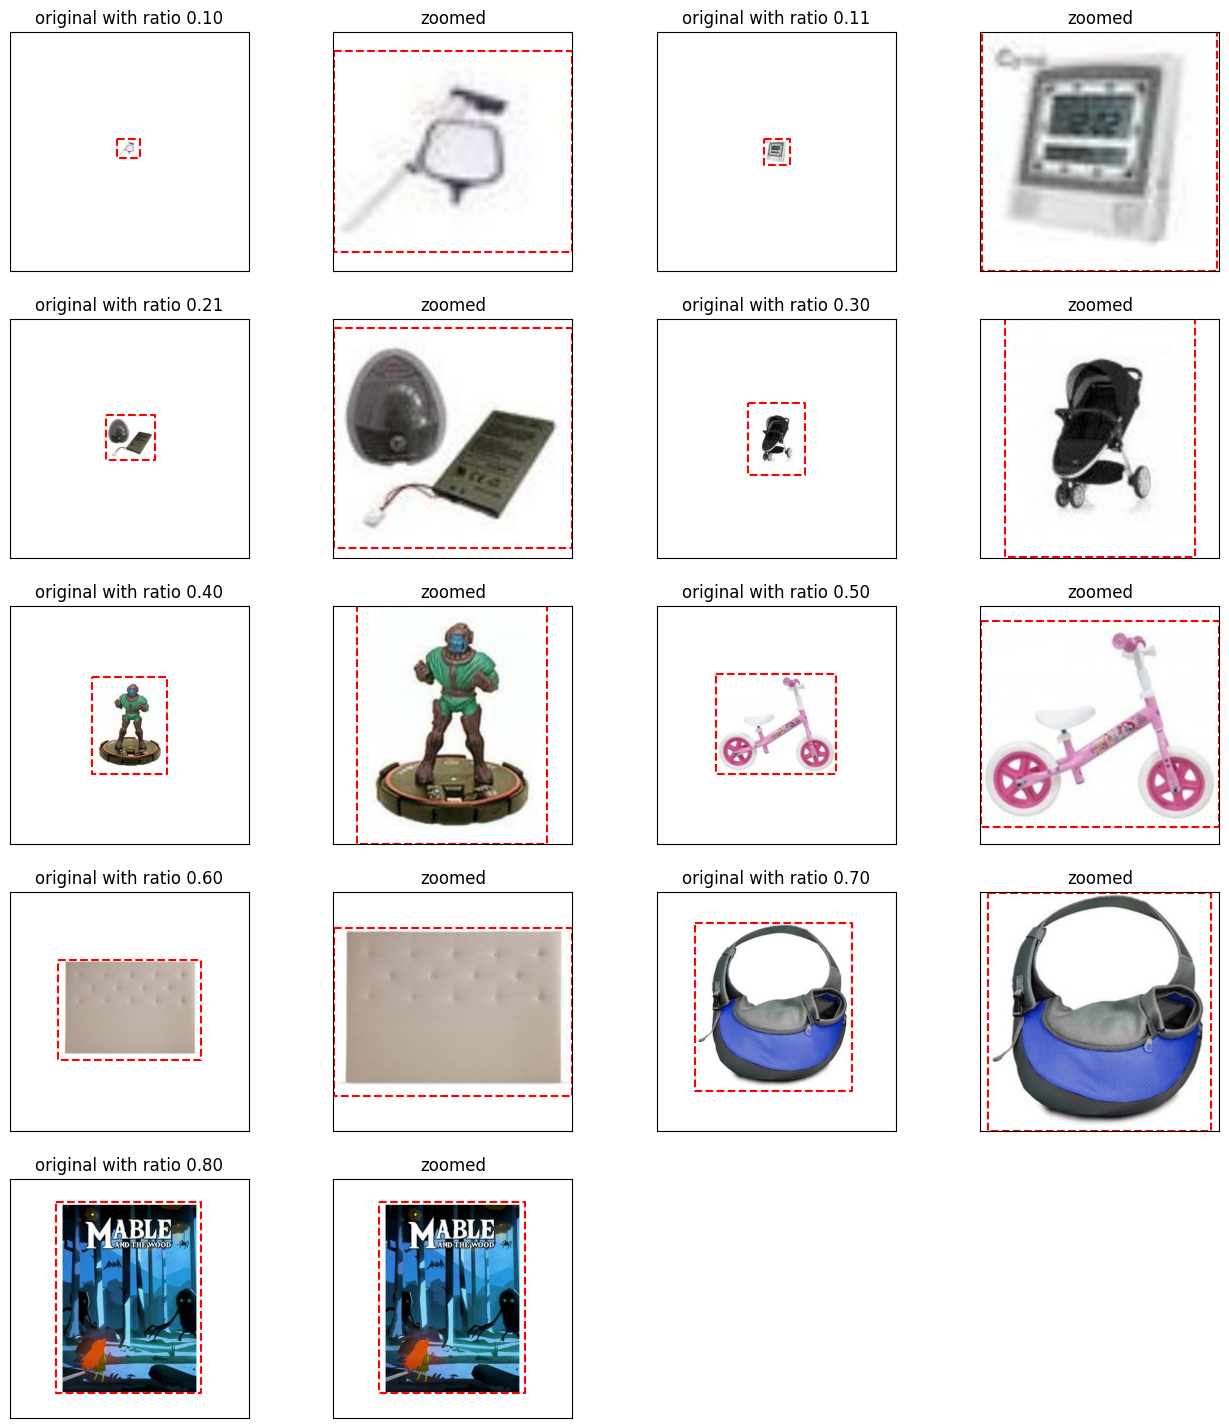

In [16]:
plt.figure(figsize=(16,18))
i = 1
for index,old_img in original_images:
  plt.subplot(5,4,i)
  row = df.loc[index]
  plot_img_with_box(old_img,row["innerimagetop"],row["innerimageleft"],row["innerimagebottom"],row["innerimageright"])
  plt.title("original with ratio %.2f" % row['innerimageratio'])

  img = cv2.imread(image_path+"/"+row['imagefile'],cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  top,left,bottom,right = find_inner_img_box(img)
  plt.subplot(5,4,i+1)
  plot_img_with_box(img,top,left,bottom,right)
  plt.title("zoomed")
  i+=2

plt.show()

Le zoom a bien fonctionné ! Les proportions de l'images originales sont conservées et la qualité est correcte. D'après les bounding box affichées, on peut voir que l'image a été agrandie autant que possible en respectant ces contraintes.

Sauvegardons le dataset **df** en supprimant les colonnes spécifiques aux images hormis **imagefile**. C'est ce csv qui servira de base au notebook **data-preprocessing-resampling**

# Export des données pre-processed

In [17]:
df = df.drop(df_img.columns,axis=1)

Path(output_dir).mkdir(parents=True, exist_ok=True)
df.to_csv(output_dir+"/df_pre.csv")

Il faut également sauvegarder les images zoomées. Nous allons générer une nouvelle archive **images_pre.zip** qu'on stockera dans le dossier **output_dir**

In [18]:
def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        print("zipping ",root,"...")
        for file in tqdm(files):
            ziph.write(os.path.join(root, file),
                       os.path.relpath(os.path.join(root, file),
                                       os.path.join(path, '..')))

with zipfile.ZipFile('/tmp/images_pre.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipdir(image_path, zipf)

zipping  /tmp/rakuten-images/images ...


0it [00:00, ?it/s]


zipping  /tmp/rakuten-images/images/2583 ...


100%|██████████| 10209/10209 [00:25<00:00, 393.69it/s]


zipping  /tmp/rakuten-images/images/1560 ...


100%|██████████| 5073/5073 [00:11<00:00, 459.88it/s]


zipping  /tmp/rakuten-images/images/1180 ...


100%|██████████| 764/764 [00:01<00:00, 417.58it/s]


zipping  /tmp/rakuten-images/images/1940 ...


100%|██████████| 803/803 [00:02<00:00, 295.72it/s]


zipping  /tmp/rakuten-images/images/2522 ...


100%|██████████| 4989/4989 [00:09<00:00, 518.19it/s]


zipping  /tmp/rakuten-images/images/2462 ...


100%|██████████| 1421/1421 [00:03<00:00, 420.85it/s]


zipping  /tmp/rakuten-images/images/60 ...


100%|██████████| 832/832 [00:02<00:00, 322.84it/s]


zipping  /tmp/rakuten-images/images/2060 ...


100%|██████████| 4993/4993 [00:11<00:00, 435.55it/s]


zipping  /tmp/rakuten-images/images/2403 ...


100%|██████████| 4774/4774 [00:13<00:00, 361.58it/s]


zipping  /tmp/rakuten-images/images/2280 ...


100%|██████████| 4760/4760 [00:13<00:00, 341.58it/s]


zipping  /tmp/rakuten-images/images/2905 ...


100%|██████████| 872/872 [00:02<00:00, 355.03it/s]


zipping  /tmp/rakuten-images/images/1280 ...


100%|██████████| 4870/4870 [00:10<00:00, 450.39it/s]


zipping  /tmp/rakuten-images/images/1320 ...


100%|██████████| 3241/3241 [00:05<00:00, 600.80it/s]


zipping  /tmp/rakuten-images/images/10 ...


100%|██████████| 3116/3116 [00:08<00:00, 388.48it/s]


zipping  /tmp/rakuten-images/images/1920 ...


100%|██████████| 4303/4303 [00:10<00:00, 418.34it/s]


zipping  /tmp/rakuten-images/images/40 ...


100%|██████████| 2508/2508 [00:08<00:00, 288.98it/s]


zipping  /tmp/rakuten-images/images/2585 ...


100%|██████████| 2496/2496 [00:04<00:00, 542.11it/s]


zipping  /tmp/rakuten-images/images/1301 ...


100%|██████████| 807/807 [00:01<00:00, 515.14it/s]


zipping  /tmp/rakuten-images/images/50 ...


100%|██████████| 1681/1681 [00:02<00:00, 586.85it/s]


zipping  /tmp/rakuten-images/images/1300 ...


100%|██████████| 5045/5045 [00:10<00:00, 496.61it/s]


zipping  /tmp/rakuten-images/images/1302 ...


100%|██████████| 2491/2491 [00:04<00:00, 505.42it/s]


zipping  /tmp/rakuten-images/images/2220 ...


100%|██████████| 824/824 [00:01<00:00, 436.62it/s]


zipping  /tmp/rakuten-images/images/1140 ...


100%|██████████| 2671/2671 [00:06<00:00, 428.82it/s]


zipping  /tmp/rakuten-images/images/2582 ...


100%|██████████| 2589/2589 [00:04<00:00, 537.38it/s]


zipping  /tmp/rakuten-images/images/2705 ...


100%|██████████| 2761/2761 [00:09<00:00, 284.35it/s]


zipping  /tmp/rakuten-images/images/1281 ...


100%|██████████| 2070/2070 [00:05<00:00, 402.83it/s]


zipping  /tmp/rakuten-images/images/1160 ...


100%|██████████| 3953/3953 [00:12<00:00, 305.07it/s]


Il ne nous reste plus qu'à déplacer l'archive dans le dossier d'output. Nous procédons ainsi en deux étapes pour éviter la multiplication d'accès à google drive qui est très lente quand on execute le notebook sur google colab.

In [19]:
shutil.copyfile("/tmp/images_pre.zip", output_dir+"/images_pre.zip")

'output/data-preprocessing-images/images_pre.zip'